In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv
/kaggle/input/sentiment-analysis-dataset/train.csv
/kaggle/input/sentiment-analysis-dataset/testdata.manual.2009.06.14.csv
/kaggle/input/sentiment-analysis-dataset/test.csv


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

2024-05-14 06:24:29.852306: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 06:24:29.852454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 06:24:29.995958: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import pandas as pd

df = pd.read_csv("/kaggle/input/sentiment-analysis-dataset/train.csv",encoding='latin1')
df=df[['text','sentiment']]
df.head(5)

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [4]:
df=df.sample(2000)

In [5]:
df.head()

,text,sentiment
17820,got an ear infection...man that **** hurts!,negative
10256,Trying to get some work done not too happy abo...,positive
7258,Now i cant find him Gonna be a sleepless nigh...,negative
4622,dude I have 2 more hours and I`m all done wit...,positive
1672,I need to do some more post but I don`t have ...,negative


<Axes: xlabel='sentiment'>

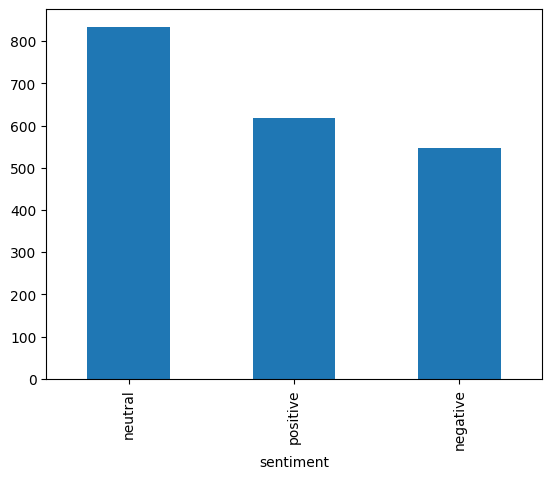

In [6]:
df['sentiment'].value_counts().plot(kind='bar')

In [7]:
df.isnull().sum()

text         0
sentiment    0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
df.dropna(inplace=True)

In [10]:
df.isnull().sum()

text         0
sentiment    0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 17820 to 13386
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       2000 non-null   object
 1   sentiment  2000 non-null   object
dtypes: object(2)
memory usage: 46.9+ KB


In [12]:
df.describe()

,text,sentiment
count,2000,2000
unique,2000,3
top,got an ear infection...man that **** hurts!,neutral
freq,1,834


In [13]:
df.head()

,text,sentiment
17820,got an ear infection...man that **** hurts!,negative
10256,Trying to get some work done not too happy abo...,positive
7258,Now i cant find him Gonna be a sleepless nigh...,negative
4622,dude I have 2 more hours and I`m all done wit...,positive
1672,I need to do some more post but I don`t have ...,negative


In [14]:
#Removing special characters
def remove_special(text):
  x=''
  for i in text:
    if i.isalnum():
      x=x+i
    else:
      x=x+' '
  return x

In [15]:
df['text']=df['text'].apply(remove_special)

In [16]:
df.head()

,text,sentiment
17820,got an ear infection man that hurts,negative
10256,Trying to get some work done not too happy abo...,positive
7258,Now i cant find him Gonna be a sleepless nigh...,negative
4622,dude I have 2 more hours and I m all done wit...,positive
1672,I need to do some more post but I don t have ...,negative


In [17]:
#Tokenizer for BERT
bert_tokenizer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
# Embedding Generator --> BERT Itself
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [18]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_tokenizer(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435168 , -0.5132724 , -0.8884571 , ..., -0.7474884 ,
        -0.7531473 ,  0.91964483],
       [-0.87208354, -0.50543964, -0.94446665, ..., -0.85847497,
        -0.7174535 ,  0.88082975]], dtype=float32)>

In [19]:
# bert_encoder(bert_tokenizer(["Hey!! what's up"]))

In [20]:
# from sklearn.metrics.pairwise import cosine_similarity
# cosine_similarity([e[0]],[e[1]])

In [21]:
# e[0].shape

In [22]:
X=get_sentence_embeding(df['text'])

In [23]:
X=X.numpy()


In [24]:
X.shape

(2000, 768)

In [25]:
from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder(sparse=False)
y=encoder.fit_transform(df['sentiment'].values.reshape(-1, 1))
y

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=2)

In [27]:
from keras import Sequential
from keras.layers import Dense

In [28]:
model = Sequential()

model.add(Dense(3,activation='softmax',input_dim=768))

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 3)              │         2,307 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,307 (9.01 KB)

 Trainable params: 2,307 (9.01 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

In [30]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=METRICS)

In [31]:
history = model.fit(X,y,epochs=500,validation_split=0.2)

Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6346 - loss: 1.1417 - precision: 0.3834 - recall: 0.1501 - val_accuracy: 0.6700 - val_loss: 1.0615 - val_precision: 0.5667 - val_recall: 0.0425
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6684 - loss: 1.0664 - precision: 0.4839 - recall: 0.0689 - val_accuracy: 0.6692 - val_loss: 1.0535 - val_precision: 0.5882 - val_recall: 0.0250
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6761 - loss: 1.0299 - precision: 0.6293 - recall: 0.0905 - val_accuracy: 0.6958 - val_loss: 1.0073 - val_precision: 0.6804 - val_recall: 0.1650
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6837 - loss: 1.0166 - precision: 0.6125 - recall: 0.1384 - val_accuracy: 0.6958 - val_loss: 0.9928 - val_precision: 0.7536 - val_recall: 0.1300
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6942 - loss: 1.0008 - precision: 0.6220 - recall: 0.2100 - val_accuracy: 0.7108 - val_loss: 1.0183 

In [32]:
model.evaluate(X_test, y_test)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7937 - loss: 0.7557 - precision: 0.7236 - recall: 0.6159 


[0.689717173576355, 0.8066666722297668, 0.7464788556098938, 0.6359999775886536]

In [33]:
sample=get_sentence_embeding(
    [
        'The movie was good',
        'The movie was not good',
        'The movie was bad',
        'The movie was average',
        'The movie was not bad',
        'The movie was extremely bad'
    ])

In [34]:
for i in model.predict(sample.numpy()):
    if np.argmax(i)==0:
        print('Negative with probability',i[0])
    elif np.argmax(i)==1:
        print('Neutral with probability',i[1])
    else:
        print('Positive with probability',i[2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Positive with probability 0.94725233
Negative with probability 0.39705193
Negative with probability 0.67627925
Negative with probability 0.5972904
Positive with probability 0.65809333
Negative with probability 0.9189424


In [35]:
model.save('/kaggle/working/model.h5')